In [1]:
Db = 'U8k'
Db = 'K20'

if Db == 'U8k':
    local_config = {
        'data_path'     : 'UrbanSound8K/audio',
        'metadata_file' : 'UrbanSound8K/metadata/UrbanSound8K.csv',
        'nb_classes'    :  10,}
else:
    local_config = {
        'data_path'     : 'LL_AudioDB/',
        'metadata_file' : 'LL_AudioDB/metadata/kitchen20b.csv',
        'nb_classes'    :  26,}  
        

In [2]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------

import pandas as pd
from pathlib import Path

data_path = local_config['data_path']

# Read metadata file
metadata_file = local_config['metadata_file']

df = pd.read_csv(metadata_file)
df.head()

,Unnamed: 0,category,fold,orig_idx,path,take,target,usr_id
0,0,blender,1,0,audio/0-158737-A-0.wav,A,0,158737
1,1,blender,1,1,audio/0-158737-B-0.wav,B,0,158737
2,2,blender,1,2,audio/0-158737-C-0.wav,C,0,158737
3,3,blender,1,3,audio/0-173319-A-0.wav,A,0,173319
4,4,blender,1,4,audio/0-173319-B-0.wav,B,0,173319


In [3]:
# Construct file path by concatenating fold and file name
if Db == 'U8k':
    df['path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str) # Urban8k

# Take relevant columns
df = df[['path', 'target']]

df.head()

,path,target
0,audio/0-158737-A-0.wav,0
1,audio/0-158737-B-0.wav,0
2,audio/0-158737-C-0.wav,0
3,audio/0-173319-A-0.wav,0
4,audio/0-173319-B-0.wav,0


In [4]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))
    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)    

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + self.df.loc[idx, 'path']
        # Get the Class ID
        class_id = self.df.loc[idx, 'target']

        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

In [6]:
from torch.utils.data import random_split

myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

#         # Second Convolution Block
#         self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu4 = nn.ReLU()
#         self.bn4 = nn.BatchNorm2d(64)
#         init.kaiming_normal_(self.conv4.weight, a=0.1)
#         self.conv4.bias.data.zero_()
#         conv_layers += [self.conv4, self.relu4, self.bn4]

#         # Linear Classifier
#         self.ap = nn.AdaptiveAvgPool2d(output_size=1)
#         self.lin = nn.Linear(in_features=64, out_features=local_config['nb_classes'])

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=32, out_features=local_config['nb_classes'])

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x


In [8]:
#pip install torchsummary 

In [9]:
from torchsummary import summary
myModel = AudioClassifier()
summary(myModel,(2, 4000, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 500, 8]          --
├─Conv2d: 1-2                            [-1, 8, 2000, 32]         408
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 8, 2000, 32]         (recursive)
├─ReLU: 1-3                              [-1, 8, 2000, 32]         --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-2                         [-1, 8, 2000, 32]         --
├─BatchNorm2d: 1-4                       [-1, 8, 2000, 32]         16
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-3                  [-1, 8, 2000, 32]         (recursive)
├─Conv2d: 1-5                            [-1, 16, 1000, 16]        1,168
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-4                       [-1, 16, 1000, 16]    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 500, 8]          --
├─Conv2d: 1-2                            [-1, 8, 2000, 32]         408
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 8, 2000, 32]         (recursive)
├─ReLU: 1-3                              [-1, 8, 2000, 32]         --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-2                         [-1, 8, 2000, 32]         --
├─BatchNorm2d: 1-4                       [-1, 8, 2000, 32]         16
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-3                  [-1, 8, 2000, 32]         (recursive)
├─Conv2d: 1-5                            [-1, 16, 1000, 16]        1,168
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-4                       [-1, 16, 1000, 16]    

In [10]:
# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)

# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [11]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            #if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')


In [12]:
num_epochs = 350   
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 2.97, Accuracy: 0.10
Epoch: 1, Loss: 2.76, Accuracy: 0.18
Epoch: 2, Loss: 2.51, Accuracy: 0.26
Epoch: 3, Loss: 2.32, Accuracy: 0.30
Epoch: 4, Loss: 2.12, Accuracy: 0.35
Epoch: 5, Loss: 1.98, Accuracy: 0.40
Epoch: 6, Loss: 1.86, Accuracy: 0.41
Epoch: 7, Loss: 1.76, Accuracy: 0.44
Epoch: 8, Loss: 1.67, Accuracy: 0.48
Epoch: 9, Loss: 1.66, Accuracy: 0.46
Epoch: 10, Loss: 1.54, Accuracy: 0.51
Epoch: 11, Loss: 1.42, Accuracy: 0.55
Epoch: 12, Loss: 1.50, Accuracy: 0.51
Epoch: 13, Loss: 1.47, Accuracy: 0.53
Epoch: 14, Loss: 1.43, Accuracy: 0.53
Epoch: 15, Loss: 1.32, Accuracy: 0.58
Epoch: 16, Loss: 1.33, Accuracy: 0.58
Epoch: 17, Loss: 1.29, Accuracy: 0.59
Epoch: 18, Loss: 1.30, Accuracy: 0.57
Epoch: 19, Loss: 1.26, Accuracy: 0.58
Epoch: 20, Loss: 1.34, Accuracy: 0.55
Epoch: 21, Loss: 1.26, Accuracy: 0.59
Epoch: 22, Loss: 1.15, Accuracy: 0.63
Epoch: 23, Loss: 1.25, Accuracy: 0.59
Epoch: 24, Loss: 1.17, Accuracy: 0.64
Epoch: 25, Loss: 1.13, Accuracy: 0.63
Epoch: 26, Loss: 1.12,

Epoch: 213, Loss: 0.49, Accuracy: 0.82
Epoch: 214, Loss: 0.48, Accuracy: 0.84
Epoch: 215, Loss: 0.44, Accuracy: 0.84
Epoch: 216, Loss: 0.46, Accuracy: 0.85
Epoch: 217, Loss: 0.43, Accuracy: 0.85
Epoch: 218, Loss: 0.42, Accuracy: 0.86
Epoch: 219, Loss: 0.46, Accuracy: 0.85
Epoch: 220, Loss: 0.45, Accuracy: 0.85
Epoch: 221, Loss: 0.43, Accuracy: 0.85
Epoch: 222, Loss: 0.49, Accuracy: 0.85
Epoch: 223, Loss: 0.54, Accuracy: 0.83
Epoch: 224, Loss: 0.37, Accuracy: 0.88
Epoch: 225, Loss: 0.40, Accuracy: 0.86
Epoch: 226, Loss: 0.46, Accuracy: 0.85
Epoch: 227, Loss: 0.36, Accuracy: 0.88
Epoch: 228, Loss: 0.43, Accuracy: 0.86
Epoch: 229, Loss: 0.44, Accuracy: 0.85
Epoch: 230, Loss: 0.44, Accuracy: 0.86
Epoch: 231, Loss: 0.51, Accuracy: 0.84
Epoch: 232, Loss: 0.44, Accuracy: 0.86
Epoch: 233, Loss: 0.39, Accuracy: 0.86
Epoch: 234, Loss: 0.45, Accuracy: 0.85
Epoch: 235, Loss: 0.41, Accuracy: 0.88
Epoch: 236, Loss: 0.39, Accuracy: 0.86
Epoch: 237, Loss: 0.41, Accuracy: 0.87
Epoch: 238, Loss: 0.39, A

In [13]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')


In [14]:
# ----------------------------
# Saving a checkpoint
# ----------------------------
import os

def save_checkpoint(model, epochs):
    model_out_path = "checkpoints/" + "model_" + "{}ep".format(epochs) 
    state = {"epoch": epochs, "model": model}
    if not os.path.exists("checkpoints/"):
        os.makedirs("checkpoints/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [15]:
# ----------------------------
# Loading a checkpoint
# ----------------------------
import os

def load_checkpoint(path):
    model = AudioClassifier()
    checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'].state_dict())
    
    return model

In [59]:
# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.83, Total items: 286


In [16]:
# Saving the trained model
save_checkpoint(myModel, num_epochs)

Checkpoint saved to checkpoints/model_350ep


In [18]:
# Loading the pre-trained model - Uncomment if needed

# epochs = 10

# model_out_path = "checkpoints/" + "model_" + "{}ep".format(epochs) 
# myModel = load_checkpoint(model_out_path)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# myModel = myModel.to(device)
# next(myModel.parameters()).device

device(type='cpu')

In [60]:
# Taux de reconnaissance par classe et confussion matrix
#import the metric classe
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [61]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [62]:
targets, preds_1 = get_all_prediction(myModel, val_dl)

In [63]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')


normalized confusion matrix


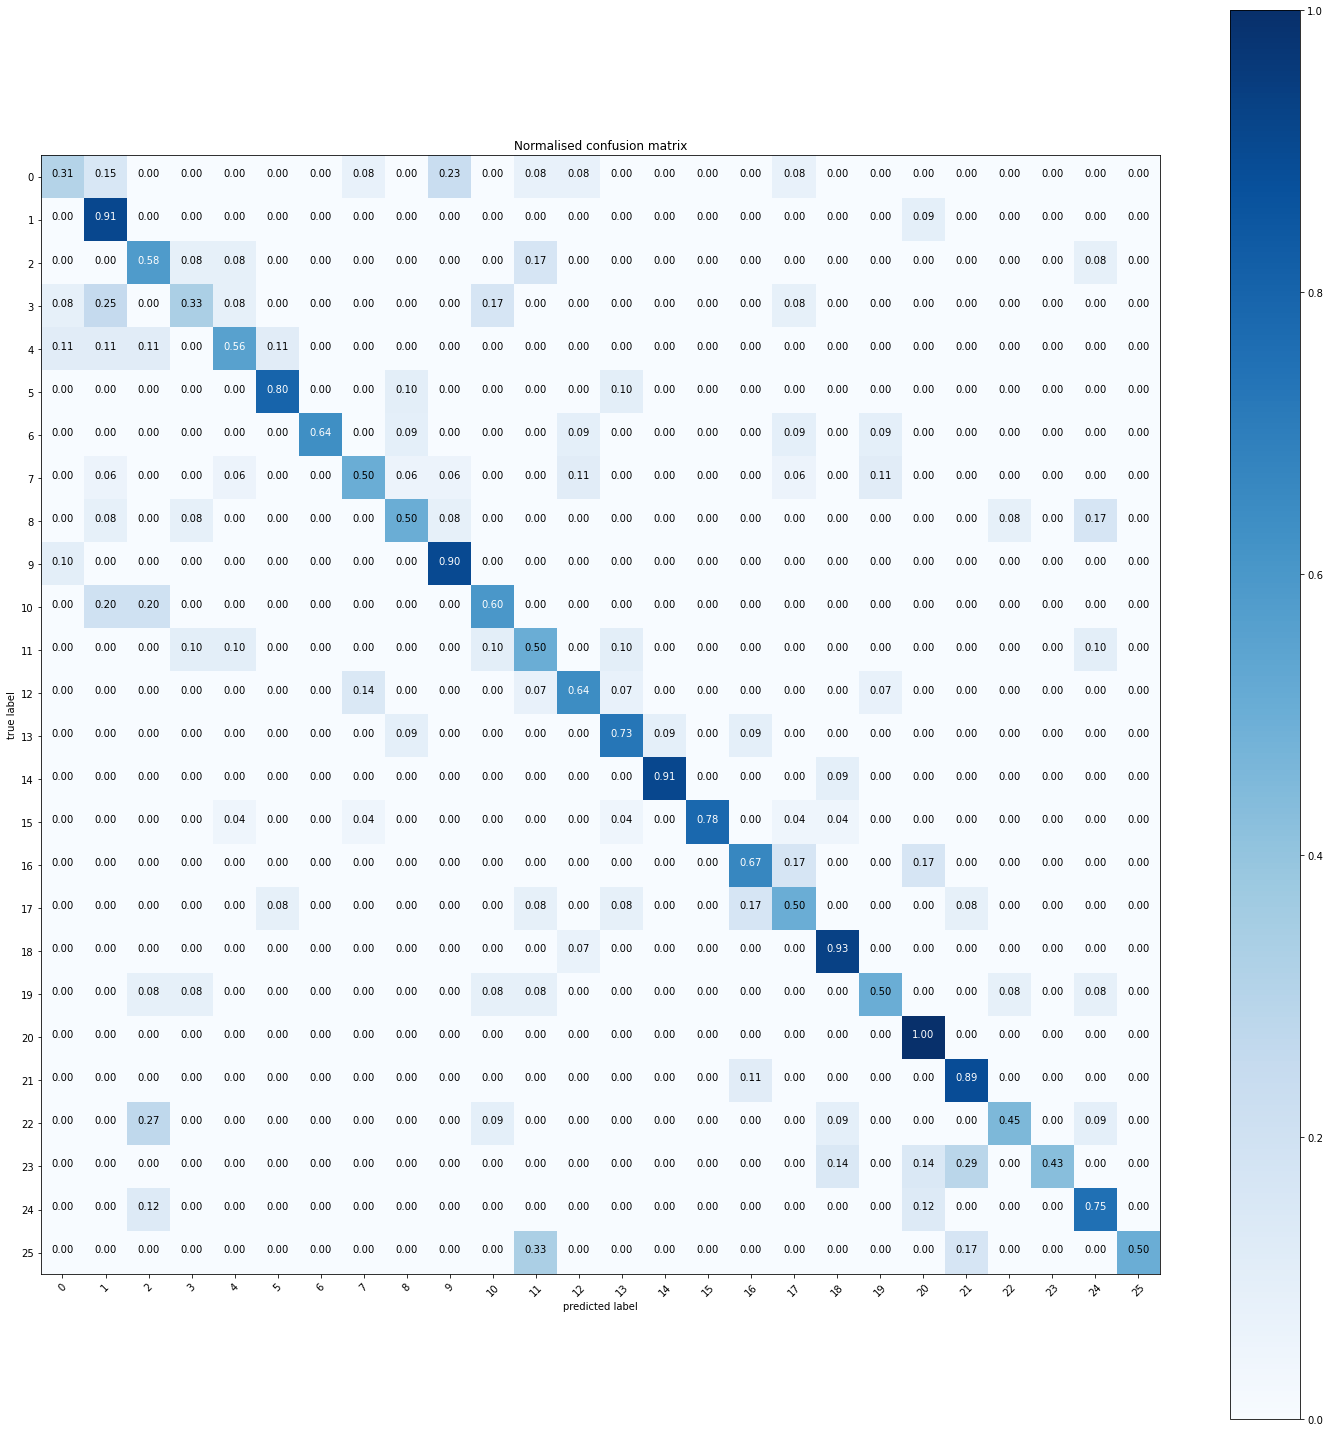

In [64]:
# compute confusion matrix
cnf_matrix = confusion_matrix(targets,preds_1)
np.set_printoptions(precision=2)


class_names = [i for i in range(26)]
# plot normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix,classes=class_names,normalize=True,title='Normalised confusion matrix')

plt.show()

In [ ]:
# blender, dishwasher, fridge, microwave, stove-fan, stove-burner, frying-pan, water-flowing, 
# boiling-water, juicer, cupboard, drawer, clean-dishes, cutlery, book, chopping, cutlery, plates, 
# eat, peel, window-blind, plates, sweep, trash, sitting-and-moving, radio, plugging, 
# moving-furniture, computer, chatting, clean-dishes

# 0: blender
# 1: dishwasher
# 2: fridge
# 3: microwave
# 4: stove-fan
# 5: stove-burner
# 6: frying-pan
# 7: water-flowing
# 8: boiling-water
# 9: juicer
# 10: cupboard
# 11: drawer
# 12: clean-dishes 
# 13: book
# 14: chopping
# 15: cutlery 
# 16: eat
# 17: peel 
# 18: plates 
# 19: sweep 
# 20: window-blind
# 21: tv
# 22: trash
# 23: radio
# 24: moving-furniture
# 25: chattering


In [65]:
targets

array([15, 23,  7,  3, 12,  7, 12, 21, 13,  6,  4,  8,  0,  0, 18, 10,  1,
        2,  2, 17, 15,  1,  6, 15,  3, 13, 25, 11, 14, 17, 18, 17,  5,  2,
       15, 19,  1, 12, 11,  0,  9, 14, 15, 18,  5, 20, 17,  0, 11,  5, 18,
        3,  1, 15,  2, 14, 21,  0, 18, 15,  3,  6, 13,  3,  6,  9, 16,  8,
       19, 18, 10, 15, 17, 12, 17, 19,  2, 17, 12, 15,  7,  0, 24, 21, 12,
        9, 22, 11, 17, 12, 11,  9, 15, 14, 15,  8, 21, 14, 19,  0,  5, 21,
        0,  6,  7,  6,  5,  7, 16, 10, 14, 12, 21, 11,  8,  8,  4, 23,  6,
        9,  3,  8, 21,  0,  4, 10,  7, 13, 20, 24, 18,  4, 24, 14,  8, 19,
       23,  2, 25,  3, 11, 12, 13,  7,  6,  5,  7, 17,  4,  4, 22,  8, 15,
       19, 15, 16, 22, 15, 24, 25,  7,  9, 16,  7,  8,  4, 24, 22,  2, 14,
        8, 24, 15, 16, 14,  3, 20,  2, 12, 21,  2, 13, 22, 21,  4,  0, 18,
       15,  7, 11,  1,  3, 18, 19, 15,  2, 13, 19,  4, 17, 13, 23, 24, 18,
       10,  1,  6, 22,  7, 18, 19, 15,  7,  0,  8, 15, 18,  1, 20, 14, 18,
       12, 25,  3,  5, 23

In [66]:
preds_1

array([15, 20, 19,  3,  7, 19, 12, 21, 13,  6,  1,  8,  0,  9, 18, 10,  1,
        2, 24,  5, 15,  1,  6, 15, 17, 13, 21, 11, 14, 17, 18, 16,  5,  2,
       13, 22,  1, 12,  3,  0,  9, 14, 15, 18,  5, 20, 17, 12, 10, 13, 18,
        1,  1, 15,  2, 14, 21,  7, 18, 15,  1, 17, 13,  3,  8,  9, 20, 24,
       19, 18,  2, 15, 17,  7, 13, 19,  3, 21, 12, 15,  4,  1, 24, 21, 13,
        9, 22, 11, 17, 12, 11,  0,  4, 14, 17,  9, 21, 18,  2, 11,  5, 21,
        1, 12, 12, 19,  8,  7, 17, 10, 14, 12, 21, 11, 24, 22,  5, 18,  6,
        9, 10,  8, 16, 17,  0, 10, 17, 13, 20, 24, 18,  4, 24, 14,  8, 19,
       23,  2, 11,  4,  4, 12, 13,  7,  6,  5,  7, 16,  4,  4, 10,  8, 15,
       19, 15, 16, 22, 15, 24, 25,  7,  9, 16,  7,  8,  4, 24, 18,  2, 14,
        1, 24,  7, 16, 14,  3, 20,  2, 12, 21,  4, 13,  2, 21,  2,  9, 18,
       15,  7, 11,  1,  0, 18, 11, 15, 11, 13,  3,  4, 17, 16, 21, 20, 18,
        1,  1,  6, 22,  1, 18, 10, 18,  9,  0,  8, 15, 18,  1, 20, 14, 12,
       12, 11,  3,  5, 23